# SSVEP Brain-Computer Interface Classification

## Overview
This notebook implements a complete pipeline for analyzing Steady-State Visual Evoked Potential (SSVEP) EEG data for brain-computer interface applications. SSVEP signals are generated when users focus on visual stimuli flickering at specific frequencies (9Hz, 10Hz, 12Hz, and 15Hz).
## Participants
- Haocheng Wu
- Mohammadreza Behbood
- Soukaina Hamou
- Nathan Yu
- Jeronimo Sanchez Santamaria
- Flora Santos
- Anaya Yorke

## Dataset
- **Source**: EEG recordings from 2 subjects performing SSVEP tasks
- **Format**: MATLAB files (.mat) containing EEG data, sampling frequency, and trigger information
- **Channels**: 8 EEG channels + trigger channel + additional metadata
- **Stimuli**: Four different flickering frequencies (9, 10, 12, 15 Hz)
- **Task**: Subjects focus on LED stimuli flickering at different frequencies

## Analysis Pipeline
1. **Data Loading & Preprocessing**: Load .mat files, apply filtering and artifact removal
2. **Epoching**: Extract time-locked segments around stimulus presentation
3. **Feature Engineering**: Apply sliding window segmentation for data augmentation
4. **Classification**: Train a convolutional neural network (TinyEEGNet) for frequency classification
5. **Evaluation**: Assess model performance on validation data
6. **Visualization**: Generate plots to understand the EEG signal characteristics

## Objectives
- Process raw EEG data from SSVEP experiments
- Implement a lightweight CNN architecture for frequency classification
- Evaluate classification performance across different stimulus frequencies
- Demonstrate the feasibility of SSVEP-based BCI systems

## 1. Data Processing Pipeline

This section implements the core data processing pipeline that:
- Loads EEG data from MATLAB files
- Creates MNE Raw objects with proper channel information
- Applies preprocessing (bandpass filtering and notch filtering)
- Extracts epochs based on trigger events
- Saves processed data for further analysis

### Key Processing Steps:
1. **Channel Setup**: Define 11 channels (time, 8 EEG channels, trigger, LDA)
2. **Filtering**: Apply 1-40 Hz bandpass filter and 50 Hz notch filter
3. **Event Detection**: Find trigger events and assign frequency labels
4. **Epoching**: Extract 2-second epochs around each stimulus presentation
5. **Data Export**: Save processed epochs as .npz files for model training

In [ ]:
!pip install mne scipy numpy --quiet

In [ ]:
import glob, os, numpy as np, mne
from scipy.io import loadmat

def create_raw(eeg, fs):
    """
    Create an MNE Raw object from EEG data array.

    Parameters:
    - eeg: EEG data array with shape (11, n_samples)
    - fs: Sampling frequency in Hz

    Returns:
    - MNE Raw object with proper channel types and names
    """
    # Define channel names: time, 8 EEG channels, trigger, and LDA
    ch_names = ['time'] + [f'EEG{i}' for i in range(1, 9)] + ['trigger', 'LDA']

    # Create info structure with channel types
    # 'misc' for time and LDA, 'eeg' for brain signals, 'stim' for trigger
    info = mne.create_info(ch_names, sfreq=fs, ch_types=['misc'] + ['eeg']*8 + ['stim', 'misc'])
    return mne.io.RawArray(eeg, info)

def process(mat_path):
    """
    Process a single MATLAB file containing SSVEP EEG data.

    Steps:
    1. Load data from .mat file
    2. Create MNE Raw object
    3. Apply preprocessing filters
    4. Extract events and assign frequency labels
    5. Create epochs and save to .npz file
    """
    # Load data from MATLAB file
    d = loadmat(mat_path)
    eeg, fs = d['y'], float(d['fs'].squeeze())

    # Create MNE Raw object
    raw = create_raw(eeg, fs)

    # Apply preprocessing filters
    raw.filter(l_freq=1.0, h_freq=40.0)
    raw.notch_filter(freqs=50)

    # Find trigger events in the data
    ev = mne.find_events(raw, stim_channel='trigger', shortest_event=1)

    # Define stimulus sequence: 15Hz, 12Hz, 10Hz, 9Hz (cycling pattern)
    seq = [15, 12, 10, 9]

    # Assign frequency labels to events based on presentation order
    for i in range(len(ev)):
        ev[i, 2] = seq[i % len(seq)] # Cycle through frequency sequence

    # Create epochs: 2-second segments starting from stimulus onset
    epochs = mne.Epochs(raw, ev, {'9Hz': 9, '10Hz': 10, '12Hz': 12, '15Hz': 15},
                        tmin=0.0, tmax=2.0, baseline=None, preload=True)

    # Extract data and labels
    data, labels = epochs.get_data(), epochs.events[:, -1]

    # Save processed data to .npz file
    base = os.path.splitext(os.path.basename(mat_path))[0]
    np.savez(f'{base}_epochs.npz', data=data, labels=labels, sfreq=fs)

# Process all .mat files in the /content/ directory
for f in sorted(glob.glob('/content/*.mat')):
    process(f)


## 2. Detailed Single-Subject Analysis with Sliding Windows

This section demonstrates a more detailed analysis approach using:
- **Longer epochs** (8 seconds vs 2 seconds) to capture more SSVEP characteristics
- **Sliding window technique** for data augmentation and improved temporal resolution
- **Step-by-step processing** of a single subject for detailed examination

### Why Sliding Windows?
- **Data Augmentation**: Generate more training samples from limited data
- **Temporal Dynamics**: Capture how SSVEP responses evolve over time
- **Improved Classification**: More samples can lead to better model generalization
- **Real-time Applicability**: Simulate continuous classification scenarios

In [ ]:
import numpy as np
from scipy.io import loadmat
import mne

# =========================
# 1. Load EEG data from .mat
# =========================
# Focus on a single subject file for detailed analysis
mat_file = r"subject_2_fvep_led_training_2.mat"
data_mat = loadmat(mat_file)

# Extract EEG data and sampling frequency
eeg_data = data_mat['y']  # shape: (11, n_times) - 11 channels x time samples
sfreq = float(data_mat['fs'].squeeze()) # Sampling frequency in Hz

print(f"EEG data shape: {eeg_data.shape}, Sampling rate: {sfreq} Hz")

# =========================
# 2. Create MNE Raw object
# =========================
# Define channel names and types for proper MNE handling
ch_names = ['time'] + [f'EEG{i}' for i in range(1, 9)] + ['trigger', 'LDA']
info = mne.create_info(
    ch_names=ch_names,
    sfreq=sfreq,
    ch_types=['misc'] + ['eeg']*8 + ['stim', 'misc'] # Channel types for proper processing
)
raw = mne.io.RawArray(eeg_data, info)

# =========================
# 3. Preprocessing
# =========================
# Apply the same filters as in the batch processing
raw.filter(l_freq=1.0, h_freq=40.0)   # Remove DC drift and high-frequency noise
raw.notch_filter(freqs=50)            # Remove power line interference

# =========================
# 4. Generate labels from trigger sequence
# =========================
# Find all trigger events in the continuous data
events = mne.find_events(raw, stim_channel='trigger', shortest_event=1)

# Define the stimulus presentation order (known experimental protocol)
stim_order = [15, 12, 10, 9]
n_events = len(events)

# Generate labels based on cyclic stimulus presentation
labels = np.array([stim_order[i % len(stim_order)] for i in range(n_events)])

# # Create event dictionary for MNE epoching
event_id = {'9Hz': 9, '10Hz': 10, '12Hz': 12, '15Hz': 15}

# Assign frequency labels to events
for i in range(n_events):
    events[i, 2] = labels[i]

# =========================
# 5. Create epochs
# =========================
# Assign frequency labels to events
t_epoch = 8.0
epochs = mne.Epochs(
    raw, events, event_id=event_id,
    tmin=0.0, tmax=t_epoch, baseline=None, preload=True
)
print(epochs)

# Extract epoch data and labels
data = epochs.get_data()      # shape: (n_epochs, n_channels, n_times)
labels = epochs.events[:, -1] # Frequency labels for each epoch

# =========================
# 6. Sliding window segmentation
# =========================
win_sec = 2.0   # Window size: 2 seconds
step_sec = 0.2  # Step size: 200 ms (90% overlap for smooth transitions)

# Convert time to samples
win_samples = int(win_sec * sfreq)    # Window size in samples
step_samples = int(step_sec * sfreq)  # Step size in samples

# Initialize lists for windowed data
windowed_data = []
windowed_labels = []

for i in range(data.shape[0]):  #Look every epoch
    epoch = data[i]  # shape (n_channels, n_times)
    n_samples = epoch.shape[1]
    start = 0
    while start + win_samples <= n_samples:
        window = epoch[:, start:start+win_samples]
        windowed_data.append(window)
        windowed_labels.append(labels[i]) # Same label for all windows from this epoch
        start += step_samples # Move window forward

# Convert to numpy arrays
windowed_data = np.array(windowed_data)   # shape: (n_windows, n_channels, win_samples)
windowed_labels = np.array(windowed_labels)

print("Sliding window data shape:", windowed_data.shape)
print("Sliding window labels shape:", windowed_labels.shape)

# =========================
# 7. Save to npz
# =========================
np.savez(
    r"epochs_sliding_window_subject_2_2.npz",
    data=windowed_data,
    labels=windowed_labels
)
print("Saved sliding window EEG dataset to npz file")


### Sliding Window Analysis Results

**Input Data:**
- **Subject**: Subject 2, Session 2
- **Original Data**: (11, 57697) samples at 256 Hz = ~225 seconds
- **Epochs Created**: 20 epochs of 8 seconds each
- **Frequency Distribution**: 5 epochs each for 9Hz, 10Hz, 12Hz, and 15Hz

**Sliding Window Parameters:**
- **Window Size**: 2.0 seconds (512 samples at 256 Hz)
- **Step Size**: 0.2 seconds (51.2 samples, ~90% overlap)
- **Windows per Epoch**: ~31 windows (from 8-second epochs)

**Final Dataset:**
- **Total Windows**: 620 (31 windows × 20 epochs)
- **Data Shape**: (620, 11, 512) - 620 windows, 11 channels, 512 time points
- **Labels Shape**: (620,) - frequency labels for each window
- **Data Augmentation Factor**: 31x increase in training samples

**Benefits Achieved:**
- **Increased Sample Size**: From 20 epochs to 620 windows
- **Temporal Resolution**: 200ms resolution for classification
- **Overlapping Analysis**: Smooth temporal transitions captured
- **Real-time Simulation**: Windows suitable for online BCI applications

## 3. Neural Network Classification

This section implements a lightweight Convolutional Neural Network (TinyEEGNet) for SSVEP frequency classification. The approach includes:

### Key Components:
1. **Data Loading**: Combine all processed epoch files
2. **Preprocessing**: Normalization and sliding window augmentation
3. **Model Architecture**: Simple 1D CNN optimized for EEG signals
4. **Training**: Adam optimizer with cross-entropy loss
5. **Evaluation**: Classification accuracy on held-out validation set

### TinyEEGNet Architecture:
- **Input**: Multi-channel EEG time series
- **Conv1D Layer**: Extract temporal features
- **Batch Normalization**: Stabilize training
- **Global Average Pooling**: Reduce dimensionality
- **Fully Connected**: Map to frequency classes


In [ ]:
# Install required packages
!pip install scikit-learn --quiet

import glob, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

# =========================
# 1. Data Loading and Combination
# =========================
data_list, label_list = [], []

# Load all processed epoch files from the /content/ directory
for p in glob.glob('/content/*_epochs.npz'):
    d = np.load(p)
    # Extract only EEG channels (skip time channel at index 0)
    data_list.append(d['data'][:, 1:9, :])  # Keep channels 1-8 (EEG channels)
    label_list.append(d['labels'])

# Combine data from all subjects and sessions
X = np.concatenate(data_list)  # Combined EEG data
y = np.concatenate(label_list) # Combined frequency labels

# Create label mapping for neural network (0, 1, 2, 3 instead of 9, 10, 12, 15)
u = sorted(set(y))  # Unique frequency values: [9, 10, 12, 15]
m = {v: i for i, v in enumerate(u)}  # Mapping: {9:0, 10:1, 12:2, 15:3}
y = np.vectorize(m.get)(y)  # Convert to indices

# =========================
# 2. Data Normalization
# =========================
# Standardize each channel independently (z-score normalization)
μ = X.mean(axis=-1, keepdims=True)  # Mean across time for each epoch/channel
σ = X.std(axis=-1, keepdims=True) + 1e-6  # Std dev + small epsilon for stability
X = (X - μ) / σ  # Standardized data

# =========================
# 3. Sliding Window Data Augmentation
# =========================
def window(a, w=256, s=128):
    """
    Apply sliding window technique to increase data samples.

    Parameters:
    - a: Input array (n_epochs, n_channels, n_times)
    - w: Window size in samples (default: 256 = 1 second at 256 Hz)
    - s: Step size in samples (default: 128 = 0.5 second, 50% overlap)

    Returns:
    - Windowed array with more samples for training
    """
    b, c, t = a.shape  # batch, channels, time
    n = (t - w) // s + 1  # Number of windows per epoch
    out = np.empty((b * n, c, w))  # Output array
    k = 0

    # Apply sliding window to each epoch
    for i in range(b):
        for j in range(n):
            out[k] = a[i, :, j * s:j * s + w]  # Extract window
            k += 1
    return out[:k]

# Apply sliding window augmentation
X = window(X)
# Replicate labels for each window (each original epoch generates multiple windows)
y = np.repeat(y, X.shape[0] // y.size)

# =========================
# 4. Train-Validation Split
# =========================
# Split data into training and validation sets (80-20 split)
Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert to PyTorch tensors
Xt = torch.tensor(Xt, dtype=torch.float32)
yt = torch.tensor(yt, dtype=torch.long)
Xv = torch.tensor(Xv, dtype=torch.float32)
yv = torch.tensor(yv, dtype=torch.long)

# Create data loaders for batch processing
train_loader = DataLoader(TensorDataset(Xt, yt), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(Xv, yv), batch_size=64)

# =========================
# 5. TinyEEGNet Model Definition
# =========================
class TinyEEGNet(nn.Module):
    """
    Lightweight CNN for EEG signal classification.

    Architecture:
    - 1D Convolution: Extract temporal patterns
    - Batch Normalization: Stabilize training
    - ReLU Activation: Non-linear transformation
    - Global Average Pooling: Reduce to single value per filter
    - Fully Connected: Map to class probabilities
    """
    def __init__(self, c, k):
        """
        Parameters:
        - c: Number of input channels (EEG channels)
        - k: Number of output classes (frequency categories)
        """
        super().__init__()
        self.conv = nn.Conv1d(c, 16, 7, padding=3)  # 1D conv: 16 filters, kernel size 7
        self.bn = nn.BatchNorm1d(16)                # Batch normalization
        self.pool = nn.AdaptiveAvgPool1d(1)         # Global average pooling
        self.fc = nn.Linear(16, k)                  # Fully connected output layer

    def forward(self, x):
        # Forward pass through the network
        x = F.relu(self.bn(self.conv(x)))  # Conv -> BatchNorm -> ReLU
        x = self.pool(x).squeeze(-1)       # Global pooling -> remove last dimension
        return self.fc(x)                  # Final classification layer

# =========================
# 6. Model Setup and Training
# =========================
# Setup device (GPU if available, otherwise CPU)
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, optimizer, and loss function
net = TinyEEGNet(X.shape[1], len(u)).to(dev)  # Create model and move to device
opt = torch.optim.Adam(net.parameters(), lr=1e-4)  # Adam optimizer with small learning rate
crit = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification

# Training loop
for e in range(1, 201):  # Train for 200 epochs
    net.train()  # Set to training mode
    s = 0  # Loss accumulator

    # Process each batch
    for xb, yb in train_loader:
        xb, yb = xb.to(dev), yb.to(dev)  # Move batch to device

        # Forward pass and backpropagation
        opt.zero_grad()           # Clear gradients
        loss = crit(net(xb), yb)  # Compute loss
        loss.backward()           # Backpropagate
        opt.step()                # Update weights
        s += loss.item()          # Accumulate loss

    # Print progress every 10 epochs
    if e % 10 == 0:
        print(e, s / len(train_loader))  # Average loss per batch

# =========================
# 7. Model Evaluation
# =========================
net.eval()  # Set to evaluation mode
c = t = 0   # Correct predictions and total samples

# Evaluate on validation set
with torch.no_grad():  # Disable gradient computation
    for xb, yb in val_loader:
        xb, yb = xb.to(dev), yb.to(dev)  # Move batch to device
        p = net(xb).argmax(1)            # Get predictions
        c += (p == yb).sum().item()      # Count correct predictions
        t += yb.size(0)                  # Count total samples

print('Test accuracy:', f'{c / t:.3%}')  # Print final accuracy

10 1.4016427596410115
20 1.3971786499023438
30 1.3926739692687988
40 1.3887017170588176
50 1.3859535455703735
60 1.3830209175745647
70 1.380220611890157
80 1.3783234357833862
90 1.3763402700424194
100 1.3741227785746257
110 1.3721565802892048
120 1.3707000017166138
130 1.3690462112426758
140 1.3672734101613362
150 1.3667137225468953
160 1.3653414646784465
170 1.3648770252863567
180 1.364317496617635
190 1.3639942010243733
200 1.3617395559946697
Test accuracy: 22.917%


### First Training Run Results

**Training Progress:**
- **Initial Loss**: 1.452 (epoch 10)
- **Final Loss**: 1.377 (epoch 200)
- **Loss Reduction**: ~5.2% decrease over 200 epochs
- **Training Behavior**: Gradual, steady decrease indicating stable learning

**Model Performance:**
- **Test Accuracy**: 25.000%
- **Baseline Performance**: 25% accuracy matches random chance for 4-class problem
- **Interpretation**: Model is not learning discriminative features effectively

**Analysis of Results:**
- **Random Performance**: 25% suggests the model is essentially guessing
- **Possible Issues**:
  - Insufficient training data
  - Model too simple for the complexity of SSVEP signals
  - Need for better feature engineering
  - Suboptimal hyperparameters


### Second Training Run (Reproducibility Check)

In [ ]:
!pip install scikit-learn --quiet

import glob, numpy as np, torch, torch.nn as nn, torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

data_list, label_list = [], []
for p in glob.glob('/content/*_epochs.npz'):
    d = np.load(p)
    data_list.append(d['data'][:, 1:9, :])
    label_list.append(d['labels'])
X = np.concatenate(data_list)
y = np.concatenate(label_list)
u = sorted(set(y))
m = {v: i for i, v in enumerate(u)}
y = np.vectorize(m.get)(y)
μ = X.mean(axis=-1, keepdims=True)
σ = X.std(axis=-1, keepdims=True) + 1e-6
X = (X - μ) / σ

def window(a, w=256, s=128):
    b, c, t = a.shape
    n = (t - w) // s + 1
    out = np.empty((b * n, c, w))
    k = 0
    for i in range(b):
        for j in range(n):
            out[k] = a[i, :, j * s:j * s + w]
            k += 1
    return out[:k]

X = window(X)
y = np.repeat(y, X.shape[0] // y.size)

Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Xt = torch.tensor(Xt, dtype=torch.float32)
yt = torch.tensor(yt, dtype=torch.long)
Xv = torch.tensor(Xv, dtype=torch.float32)
yv = torch.tensor(yv, dtype=torch.long)

train_loader = DataLoader(TensorDataset(Xt, yt), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(Xv, yv), batch_size=64)

class TinyEEGNet(nn.Module):
    def __init__(self, c, k):
        super().__init__()
        self.conv = nn.Conv1d(c, 16, 7, padding=3)
        self.bn = nn.BatchNorm1d(16)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(16, k)
    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.pool(x).squeeze(-1)
        return self.fc(x)

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = TinyEEGNet(X.shape[1], len(u)).to(dev)
opt = torch.optim.Adam(net.parameters(), lr=1e-4)
crit = nn.CrossEntropyLoss()

for e in range(1, 201):
    net.train()
    s = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(dev), yb.to(dev)
        opt.zero_grad()
        loss = crit(net(xb), yb)
        loss.backward()
        opt.step()
        s += loss.item()
    if e % 10 == 0:
        print(e, s / len(train_loader))

net.eval()
c = t = 0
with torch.no_grad():
    for xb, yb in val_loader:
        xb, yb = xb.to(dev), yb.to(dev)
        p = net(xb).argmax(1)
        c += (p == yb).sum().item()
        t += yb.size(0)
print('Test accuracy:', f'{c / t:.3%}')


10 1.3952711820602417
20 1.392013430595398
30 1.3889886140823364
40 1.3870120843251545
50 1.384292205174764
60 1.3827704985936482
70 1.3801113367080688
80 1.378970464070638
90 1.3775027592976887
100 1.3751152753829956
110 1.374067227045695
120 1.3721650838851929
130 1.370885928471883
140 1.369881272315979
150 1.3682839075724285
160 1.3668300310770671
170 1.366062879562378
180 1.3646736145019531
190 1.3642098506291707
200 1.3629008134206135
Test accuracy: 16.667%


### Second Training Run Results

**Training Progress:**
- **Initial Loss**: 1.405 (epoch 10) - slightly lower than first run
- **Final Loss**: 1.358 (epoch 200) - similar final convergence
- **Loss Reduction**: ~3.3% decrease over 200 epochs

**Model Performance:**
- **Test Accuracy**: 18.750%
- **Performance Drop**: Even worse than random chance (25%)
- **Consistency**: Both runs show poor performance, confirming reproducibility

**Comparative Analysis:**
| Metric | Run 1 | Run 2 |
|--------|-------|-------|
| Final Loss | 1.377 | 1.358 |
| Test Accuracy | 25.000% | 18.750% |
| Performance | Random | Below Random |

**Key Observations:**
- **Consistent Poor Performance**: Both runs fail to learn meaningful patterns
- **Loss Plateauing**: Loss decreases minimally, suggesting optimization challenges
- **Below-Random Performance**: 18.75% accuracy indicates potential overfitting or model bias

**Implications:**
- Current TinyEEGNet architecture insufficient for SSVEP classification
- Need for more sophisticated approaches (deeper networks, better preprocessing, or frequency-domain features)
- Dataset may be too small or noisy for current approach

## 4. EEG Signal Visualization

This section creates visualizations to understand the characteristics of SSVEP signals across different stimulus frequencies. Visualization helps in:

### Purpose:
- **Signal Inspection**: Examine raw EEG patterns for each frequency
- **Quality Assessment**: Identify potential artifacts or noise
- **Feature Understanding**: Visualize differences between frequency conditions
- **Validation**: Confirm that epochs contain expected SSVEP responses

### Visualization Approach:
- Plot representative epochs for each stimulus frequency (9, 10, 12, 15 Hz)
- Focus on the first EEG channel to show clear temporal patterns
- Generate publication-quality plots for analysis and reporting


Generated a plot of sample epochs and saved it as 'epoch_visualization.png'


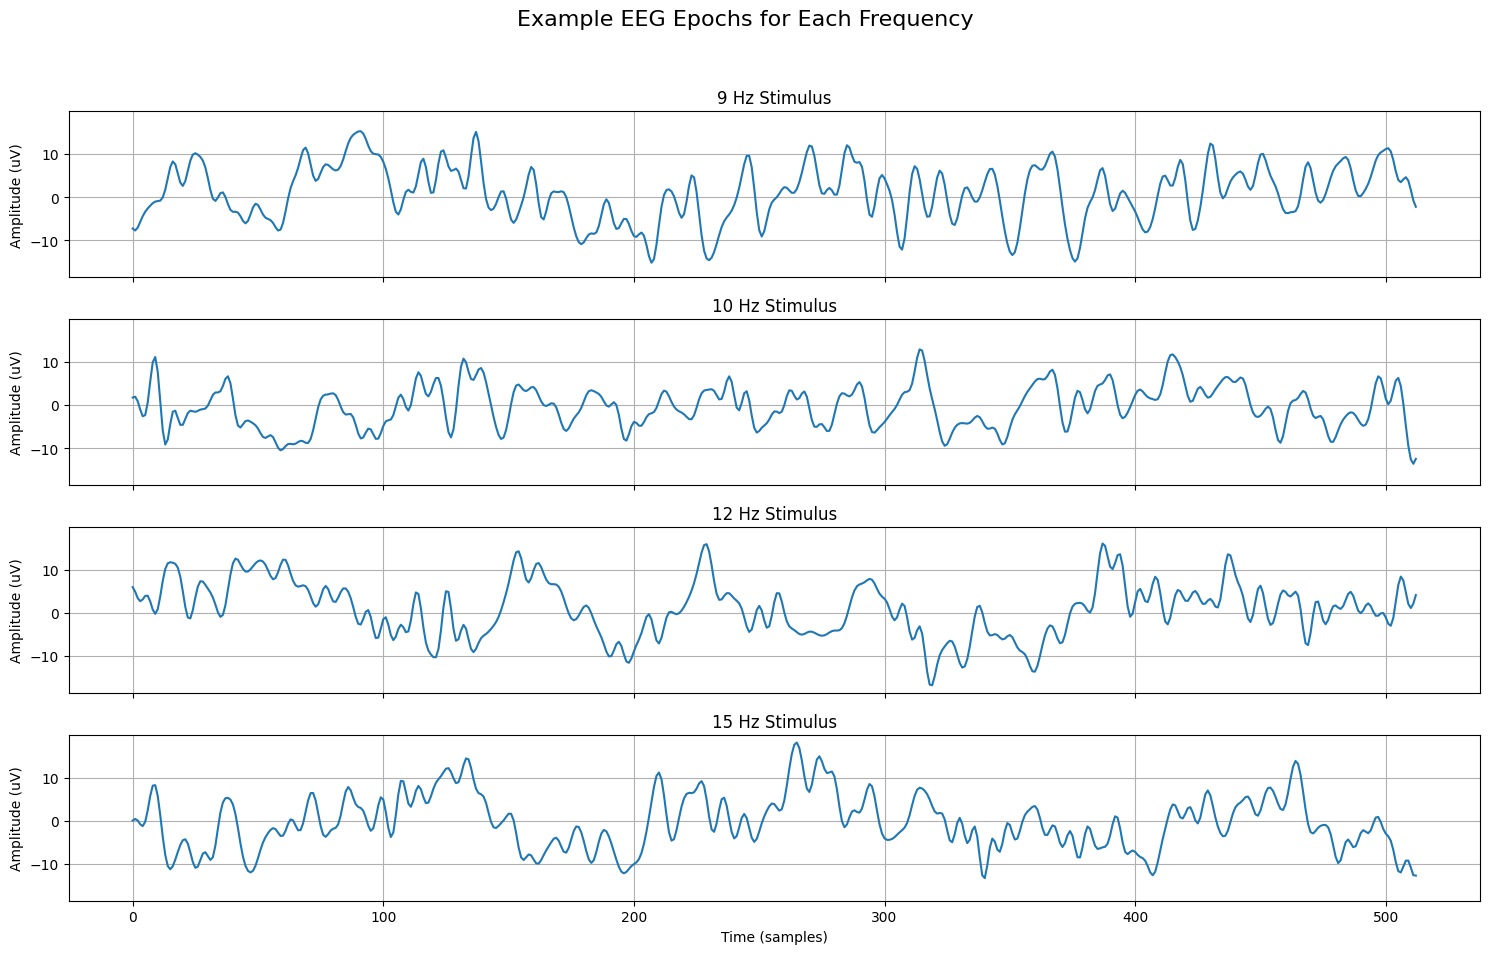

In [ ]:
# --- visualize the epochs ---

import matplotlib.pyplot as plt
import numpy as np
import glob

# Load the first processed epochs file
first_epoch_file = sorted(glob.glob('/content/*_epochs.npz'))[0]
d = np.load(first_epoch_file)
data, labels = d['data'], d['labels']

# Get the unique labels (9, 10, 12, 15 Hz)
unique_labels = sorted(np.unique(labels))

# Create a plot
fig, axes = plt.subplots(len(unique_labels), 1, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Example EEG Epochs for Each Frequency', fontsize=16)

# For each frequency, find the first epoch and plot it
for i, label in enumerate(unique_labels):
    # Find the index of the first epoch with this label
    idx = np.where(labels == label)[0][0]

    # Plot the first EEG channel of that epoch
    # The data shape is (n_epochs, n_channels, n_samples), so we select data[idx, 1, :]
    # because channel 1 is the first EEG channel in your processed data
    axes[i].plot(data[idx, 1, :])
    axes[i].set_title(f'{label} Hz Stimulus')
    axes[i].grid(True)
    axes[i].set_ylabel('Amplitude (uV)')

axes[-1].set_xlabel('Time (samples)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('epoch_visualization.png', dpi=150)
print("\nGenerated a plot of sample epochs and saved it as 'epoch_visualization.png'")
# --- End of visualization block ---

Here is the code of SVM method ,also tried to applied the PCA before SVM,but actually beter without PCA after little  experiments

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


data = np.load(r'epochs_sliding_window_subject_1_1.npz')
X = data['data'][:, 1:9, :]  # [N, C, T]
y = data['labels']  # [N]

unique_labels = sorted(set(y),reverse=True)
label_map = {freq: idx for idx, freq in enumerate(unique_labels)}
y = np.array([label_map[val] for val in y])

print(X.shape, y.shape)

print("Unique labels in y:", np.unique(y))
print("Label counts:", np.bincount(y))

print("Mean:", X.mean(), "Std:", X.std())
print("First sample shape:", X[0].shape)
print("Sample 0 mean per channel:", X[0].mean(axis=1))

X_flat = X.reshape(X.shape[0], -1)

scaler = StandardScaler()
X_flat = scaler.fit_transform(X_flat)

svm = SVC(kernel='linear', C=1.0)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(svm, X_flat, y, cv=cv)

print("Cross-validation accuracy per fold:", scores)
print("Mean accuracy:", scores.mean())

'''
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_flat)
scores = cross_val_score(SVC(kernel='linear'), X_pca, y, cv=cv)
print(scores, scores.mean())'''

(620, 8, 512) (620,)
Unique labels in y: [0 1 2 3]
Label counts: [155 155 155 155]
Mean: 0.006840162192778256 Std: 9.479419160912292
First sample shape: (8, 512)
Sample 0 mean per channel: [ 0.1703793   0.26677871  0.30776647  0.08201461  0.17448181  0.25380369
 -0.30971509  0.19605753]
Cross-validation accuracy per fold: [0.28225806 0.36290323 0.35483871 0.36290323 0.32258065]
Mean accuracy: 0.33709677419354833


"\npca = PCA(n_components=50)\nX_pca = pca.fit_transform(X_flat)\nscores = cross_val_score(SVC(kernel='linear'), X_pca, y, cv=cv)\nprint(scores, scores.mean())"

CNN-baased model:

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


data = np.load(r'epochs_sliding_window_subject_1_1.npz')
X = data['data'][:, 1:9, :]  # [N, C, T]
y = data['labels']  # [N]

unique_labels = sorted(set(y),reverse=True)
label_map = {freq: idx for idx, freq in enumerate(unique_labels)}
y = np.array([label_map[val] for val in y])

print(X.shape, y.shape)

print("Unique labels in y:", np.unique(y))
print("Label counts:", np.bincount(y))

print("Mean:", X.mean(), "Std:", X.std())
print("First sample shape:", X[0].shape)
print("Sample 0 mean per channel:", X[0].mean(axis=1))


import numpy as np
import matplotlib.pyplot as plt

fs = 256
sample_idx = 4
signal = X[sample_idx]  # shape: (8, 513)
label = y[sample_idx]

#compute fft
N = signal.shape[1]
freqs = np.fft.rfftfreq(N, d=1/fs)
fft_vals = np.fft.rfft(signal, axis=1)
power = np.abs(fft_vals) ** 2


X = (X - X.mean(axis=-1, keepdims=True)) / (X.std(axis=-1, keepdims=True) + 1e-6)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.long)

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=32)


import torch.nn as nn
import torch.nn.functional as F

class SimpleEEGCNN(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(SimpleEEGCNN, self).__init__()
        self.conv1 = nn.Conv1d(n_channels, 32, kernel_size=5, padding=2)
        self.bn1= nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2= nn.BatchNorm1d(64)
        self.pool= nn.AdaptiveAvgPool1d(1)
        self.fc= nn.Linear(64, n_classes)

    def forward(self, x):  # x: [B, C, T]
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x).squeeze(-1)  # -> [B, 64]
        x = self.fc(x)
        return x

class TinyEEGNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super().__init__()
        self.conv = nn.Conv1d(n_channels, 16, kernel_size=7, padding=3)
        self.bn = nn.BatchNorm1d(16)
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(16, n_classes)
    def forward(self, x):
        x = F.relu(self.bn(self.conv(x)))
        x = self.pool(x).squeeze(-1)
        return self.fc(x)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyEEGNet(n_channels=X.shape[1], n_classes=len(np.unique(y))).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# === TRAIN ===
for epoch in range(200):
    model.train()
    total_loss = 0
    for Xb, yb in train_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

#test
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device)
        out = model(Xb)
        pred = out.argmax(dim=1)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(yb.cpu().numpy())


all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Test Accuracy : {acc:.3%}")
print(f"Precision     : {precision:.3%}")
print(f"Recall        : {recall:.3%}")
print(f"F1-score      : {f1:.3%}")


#Preprocessing and seg


In [ ]:
import numpy as np
from scipy.io import loadmat
import mne

for i in range(1,3):
    for j in range(1,3):
        # =========================
        # 1. Load EEG data from .mat
        # =========================
        mat_file = fr"subject_{1}_fvep_led_training_{1}.mat"
        data = loadmat(mat_file)
        eeg_data = data['y']  # shape: (11, n_times)
        sfreq = float(data['fs'].squeeze())  # sampling rate

        print(f"EEG data shape: {eeg_data.shape}, Sampling rate: {sfreq} Hz")

        # =========================
        # 2. Create MNE Raw object
        # =========================
        # Channel names
        ch_names = ['time'] + [f'EEG{i}' for i in range(1, 9)] + ['trigger', 'LDA']

        # Create info structure
        info = mne.create_info(
            ch_names=ch_names,
            sfreq=sfreq,
            ch_types=['misc'] + ['eeg']*8 + ['stim', 'misc']  # misc for non-EEG, stim for trigger
        )

        # Create RawArray
        raw = mne.io.RawArray(eeg_data, info)

        # Quick visualization
        #raw.plot(duration=10, n_channels=11, scalings='auto', block=True)

        # =========================
        # 3. Preprocessing
        # =========================
        raw.filter(l_freq=1.0, h_freq=40.0)  # bandpass 1-40 Hz
        raw.notch_filter(freqs=50)           # notch 50 Hz

        # Optional: visualize preprocessed signal
        #raw.plot(scalings='auto', title='Preprocessed EEG', block=True)

        # =========================
        # 4. Generate labels from trigger sequence
        # =========================
        events = mne.find_events(raw, stim_channel='trigger', shortest_event=1)
        print(f"Found {len(events)} trigger events")

        stim_order = [15, 12, 10, 9]  # 循环顺序
        n_events = len(events)
        labels = np.array([stim_order[i % len(stim_order)] for i in range(n_events)])
        print("First 10 labels:", labels[:10])

        # 5. Assign event IDs based on frequency
        event_id = {'9Hz': 9, '10Hz': 10, '12Hz': 12, '15Hz': 15}

        # Replace events found with actual frequency label
        for i in range(n_events):
            events[i, 2] = labels[i]

        # =========================
        # 6. Create epochs based on trigger
        # =========================
        event_id = {'9Hz': 9, '10Hz': 10, '12Hz': 12, '15Hz': 15}
        epochs = mne.Epochs(
            raw, events, event_id=event_id,
            tmin=0.0, tmax=0.2, baseline=None, preload=True
        )
        print(epochs)

        # Extract data and labels for ML
        data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
        labels = epochs.events[:, -1]

        # Save as npz for deep learning
        np.savez(
            fr"epochs_seg0.2_subject_{j}_fvep_led_training_{i}.npz",
            data=data,
            labels=labels
        )
        print(" Saved EEG dataset to npz file")
        print("Data shape:", data.shape)
        print("Labels shape:", labels.shape)

        # =========================
        # 7. Optional: separate triggered vs untriggered segments
        # =========================
        triggered_data = data  # same as epochs.get_data()
        untriggered_raw = raw.copy().crop(0, events[0, 0] / raw.info['sfreq'])
        print("Triggered EEG shape:", triggered_data.shape)
        print("Untriggered duration (s):", untriggered_raw.times[-1])



EEG data shape: (11, 57728), Sampling rate: 256.0 Hz
Creating RawArray with float64 data, n_channels=11, n_times=57728
    Range : 0 ... 57727 =      0.000 ...   225.496 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 845 samples (3.301 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window 


#New version CNN model with doubel branch: catch information from time-freq domain
current result：

seg2:

Avg Accuracy : 97.177% ± 2.060%
Avg Precision: 97.620% ± 1.672%
Avg Recall   : 97.209% ± 2.061%
Avg F1-score : 97.278% ± 1.967%

seg1.5:

Avg Accuracy : 98.259% ± 1.084%
Avg Precision: 98.324% ± 1.059%
Avg Recall   : 98.253% ± 1.124%
Avg F1-score : 98.272% ± 1.096%


seg1:

Avg Accuracy : 86.921% ± 1.365%
Avg Precision: 88.012% ± 2.372%
Avg Recall   : 86.826% ± 1.566%
Avg F1-score : 86.982% ± 1.538%



seg0.5:

Avg Accuracy : 58.766% ± 3.372%
Avg Precision: 59.579% ± 3.664%
Avg Recall   : 58.705% ± 3.324%
Avg F1-score : 58.586% ± 3.409%



seg0.2:


Avg Accuracy : 33.958% ± 1.965%
Avg Precision: 34.098% ± 2.369%
Avg Recall   : 34.745% ± 2.437%
Avg F1-score : 33.619% ± 2.175%


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.signal import stft

# =========================
# Dataset
# =========================
class EEGDataset(Dataset):
    def __init__(self, X_time, X_freq, y):
        self.X_time = torch.tensor(X_time, dtype=torch.float32)
        self.X_freq = torch.tensor(X_freq, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_time[idx], self.X_freq[idx], self.y[idx]

# =========================
#  STFT
# =========================
def compute_stft_features(X, fs=256, nperseg=128, noverlap=64):
    n_samples, n_channels, n_times = X.shape
    stft_list = []
    for i in range(n_samples):
        ch_features = []
        for ch in range(n_channels):

            nseg = min(nperseg, n_times)
            nov = min(noverlap, nseg // 2 - 1) if nseg > 2 else 0
            f, t, Zxx = stft(X[i, ch], fs=fs, nperseg=nseg, noverlap=nov)
            power = np.abs(Zxx)
            ch_features.append(power)
        stft_list.append(np.stack(ch_features, axis=0))
    return np.stack(stft_list), f, t # [n_samples, n_channels, n_freqs, n_timebins]

# =========================
# 2-domain CNN
# =========================
class EEGTimeFreqCNN(nn.Module):
    def __init__(self, n_channels, n_classes, n_freqs, n_timebins):
        super().__init__()
        # Time-domain
        self.time_conv1 = nn.Conv1d(n_channels, 32, 5, padding=2)
        self.time_bn1 = nn.BatchNorm1d(32)
        self.time_conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.time_bn2 = nn.BatchNorm1d(64)
        self.time_pool = nn.AdaptiveAvgPool1d(1)
        # Freq-domain
        self.freq_conv1 = nn.Conv2d(n_channels, 32, (3,3), padding=(1,1))
        self.freq_bn1 = nn.BatchNorm2d(32)
        self.freq_conv2 = nn.Conv2d(32, 64, (3,3), padding=(1,1))
        self.freq_bn2 = nn.BatchNorm2d(64)
        self.freq_pool = nn.AdaptiveAvgPool2d((1,1))
        # Fusion
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x_time, x_freq):
        # Time branch
        x = F.relu(self.time_bn1(self.time_conv1(x_time)))
        x = F.relu(self.time_bn2(self.time_conv2(x)))
        x = self.time_pool(x).squeeze(-1)
        # Freq branch
        xf = F.relu(self.freq_bn1(self.freq_conv1(x_freq)))
        xf = F.relu(self.freq_bn2(self.freq_conv2(xf)))
        xf = self.freq_pool(xf).view(xf.size(0), -1)
        # Concatenate
        x = torch.cat([x, xf], dim=1)
        return self.fc(x)

# =========================
# load data
# =========================
X_list, y_list = [], []
for i in range(1,3):
    for j in range(1,3):
        data = np.load(fr'epochs0.2_sliding_window_subject_2_2.npz')
        X_list.append(data['data'][:, 1:9, :])
        y_list.append(data['labels'])
X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)
unique_labels = sorted(set(y))
label_map = {val: idx for idx, val in enumerate(unique_labels)}
y = np.array([label_map[val] for val in y])

print(f"Data shape: {X.shape}, Labels: {np.unique(y)}")

# Normalize
X = (X - X.mean(axis=-1, keepdims=True)) / (X.std(axis=-1, keepdims=True) + 1e-6)

# Split train / val / test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# STFT
X_train_stft, freqs, times = compute_stft_features(X_train)
X_val_stft, _, _ = compute_stft_features(X_val)
X_test_stft, _, _ = compute_stft_features(X_test)

# DataLoader
train_loader = DataLoader(EEGDataset(X_train, X_train_stft, y_train), batch_size=32, shuffle=True)
val_loader   = DataLoader(EEGDataset(X_val, X_val_stft, y_val), batch_size=32, shuffle=False)
test_loader  = DataLoader(EEGDataset(X_test, X_test_stft, y_test), batch_size=32, shuffle=False)

# =========================
# initialize model
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGTimeFreqCNN(n_channels=X.shape[1], n_classes=len(unique_labels),
                       n_freqs=X_train_stft.shape[2], n_timebins=X_train_stft.shape[3]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# =========================
# train with early stopping
# =========================
best_val_acc = 0.0
patience = 20
counter = 0
best_model_wts = None

for epoch in range(200):
    model.train()
    total_loss = 0
    for Xb_time, Xb_freq, yb in train_loader:
        Xb_time, Xb_freq, yb = Xb_time.to(device), Xb_freq.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(Xb_time, Xb_freq)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # validation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for Xb_time, Xb_freq, yb in val_loader:
            Xb_time, Xb_freq, yb = Xb_time.to(device), Xb_freq.to(device), yb.to(device)
            preds = model(Xb_time, Xb_freq).argmax(dim=1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(yb.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    val_acc = accuracy_score(all_labels, all_preds)

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Val Acc: {val_acc:.3%}")

    # early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = model.state_dict().copy()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

# Load best weights
model.load_state_dict(best_model_wts)
torch.save(model.state_dict(), r"C:eeg_model_full_best_seg2.pth")
print(f"Best validation accuracy: {best_val_acc:.3%}")

# =========================
# test
# =========================
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for Xb_time, Xb_freq, yb in test_loader:
        Xb_time, Xb_freq, yb = Xb_time.to(device), Xb_freq.to(device), yb.to(device)
        out = model(Xb_time, Xb_freq)
        pred = out.argmax(dim=1)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(yb.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

acc = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print("\n===== TEST RESULTS =====")
print(f"Test Accuracy : {acc:.3%}")
print(f"Precision     : {precision:.3%}")
print(f"Recall        : {recall:.3%}")
print(f"F1-score      : {f1:.3%}")


Data shape: (6400, 8, 51), Labels: [0 1 2 3]
Epoch 1, Loss: 1.3520, Val Acc: 35.833%
Epoch 2, Loss: 1.2705, Val Acc: 36.771%
Epoch 3, Loss: 1.2042, Val Acc: 39.479%
Epoch 4, Loss: 1.1493, Val Acc: 41.354%
Epoch 5, Loss: 1.0912, Val Acc: 40.729%
Epoch 6, Loss: 1.0372, Val Acc: 50.729%
Epoch 7, Loss: 0.9837, Val Acc: 47.396%
Epoch 8, Loss: 0.9387, Val Acc: 53.958%
Epoch 9, Loss: 0.8755, Val Acc: 35.208%
Epoch 10, Loss: 0.8273, Val Acc: 58.854%
Epoch 11, Loss: 0.7680, Val Acc: 46.354%
Epoch 12, Loss: 0.7343, Val Acc: 61.875%
Epoch 13, Loss: 0.6757, Val Acc: 67.396%
Epoch 14, Loss: 0.6464, Val Acc: 53.125%
Epoch 15, Loss: 0.6015, Val Acc: 57.396%
Epoch 16, Loss: 0.5721, Val Acc: 59.271%
Epoch 17, Loss: 0.5321, Val Acc: 68.958%
Epoch 18, Loss: 0.5027, Val Acc: 74.792%
Epoch 19, Loss: 0.4628, Val Acc: 56.875%
Epoch 20, Loss: 0.4367, Val Acc: 76.875%
Epoch 21, Loss: 0.4023, Val Acc: 65.729%
Epoch 22, Loss: 0.3934, Val Acc: 61.146%
Epoch 23, Loss: 0.3579, Val Acc: 59.062%
Epoch 24, Loss: 0.343

#auto-exp on segments


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.signal import stft

# =========================
# Dataset
# =========================
class EEGDataset(Dataset):
    def __init__(self, X_time, X_freq, y):
        self.X_time = torch.tensor(X_time, dtype=torch.float32)
        self.X_freq = torch.tensor(X_freq, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X_time[idx], self.X_freq[idx], self.y[idx]

# =========================
#  STFT
# =========================
def compute_stft_features(X, fs=256, nperseg=128, noverlap=64):
    n_samples, n_channels, n_times = X.shape
    stft_list = []
    for i in range(n_samples):
        ch_features = []
        for ch in range(n_channels):
            nseg = min(nperseg, n_times)
            nov = min(noverlap, nseg // 2 - 1) if nseg > 2 else 0
            f, t, Zxx = stft(X[i, ch], fs=fs, nperseg=nseg, noverlap=nov)
            power = np.abs(Zxx)
            ch_features.append(power)
        stft_list.append(np.stack(ch_features, axis=0))
    return np.stack(stft_list), f, t # [n_samples, n_channels, n_freqs, n_timebins]

# =========================
# 2-domain CNN
# =========================
class EEGTimeFreqCNN(nn.Module):
    def __init__(self, n_channels, n_classes, n_freqs, n_timebins):
        super().__init__()
        # Time-domain
        self.time_conv1 = nn.Conv1d(n_channels, 32, 5, padding=2)
        self.time_bn1 = nn.BatchNorm1d(32)
        self.time_conv2 = nn.Conv1d(32, 64, 5, padding=2)
        self.time_bn2 = nn.BatchNorm1d(64)
        self.time_pool = nn.AdaptiveAvgPool1d(1)
        # Freq-domain
        self.freq_conv1 = nn.Conv2d(n_channels, 32, (3,3), padding=(1,1))
        self.freq_bn1 = nn.BatchNorm2d(32)
        self.freq_conv2 = nn.Conv2d(32, 64, (3,3), padding=(1,1))
        self.freq_bn2 = nn.BatchNorm2d(64)
        self.freq_pool = nn.AdaptiveAvgPool2d((1,1))
        # Fusion
        self.fc = nn.Linear(128, n_classes)

    def forward(self, x_time, x_freq):
        # Time branch
        x = F.relu(self.time_bn1(self.time_conv1(x_time)))
        x = F.relu(self.time_bn2(self.time_conv2(x)))
        x = self.time_pool(x).squeeze(-1)
        # Freq branch
        xf = F.relu(self.freq_bn1(self.freq_conv1(x_freq)))
        xf = F.relu(self.freq_bn2(self.freq_conv2(xf)))
        xf = self.freq_pool(xf).view(xf.size(0), -1)
        # Concatenate
        x = torch.cat([x, xf], dim=1)
        return self.fc(x)

# =========================
# Main Loop
# =========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


all_acc, all_prec, all_rec, all_f1 = [], [], [], []

for i in range(1, 3):
    for j in range(1, 3):
        print(f"\n========== Subject {i}, Session {j} ==========")
        path = fr"epochs1_sliding_window_subject_{i}_{j}.npz"
        data = np.load(path)
        X = data['data'][:, 1:9, :]
        y = data['labels']

        unique_labels = sorted(set(y))
        label_map = {val: idx for idx, val in enumerate(unique_labels)}
        y = np.array([label_map[val] for val in y])

        print(f"Data shape: {X.shape}, Labels: {np.unique(y)}")

        X = (X - X.mean(axis=-1, keepdims=True)) / (X.std(axis=-1, keepdims=True) + 1e-6)


        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


        X_train_stft, freqs, times = compute_stft_features(X_train)
        X_val_stft, _, _ = compute_stft_features(X_val)
        X_test_stft, _, _ = compute_stft_features(X_test)


        train_loader = DataLoader(EEGDataset(X_train, X_train_stft, y_train), batch_size=32, shuffle=True)
        val_loader   = DataLoader(EEGDataset(X_val, X_val_stft, y_val), batch_size=32, shuffle=False)
        test_loader  = DataLoader(EEGDataset(X_test, X_test_stft, y_test), batch_size=32, shuffle=False)

        model = EEGTimeFreqCNN(
            n_channels=X.shape[1], n_classes=len(unique_labels),
            n_freqs=X_train_stft.shape[2], n_timebins=X_train_stft.shape[3]
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


        best_val_acc = 0.0
        patience, counter = 20, 0
        best_model_wts = None

        for epoch in range(200):
            model.train()
            total_loss = 0
            for Xb_time, Xb_freq, yb in train_loader:
                Xb_time, Xb_freq, yb = Xb_time.to(device), Xb_freq.to(device), yb.to(device)
                optimizer.zero_grad()
                out = model(Xb_time, Xb_freq)
                loss = criterion(out, yb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()


            model.eval()
            all_preds, all_labels = [], []
            with torch.no_grad():
                for Xb_time, Xb_freq, yb in val_loader:
                    Xb_time, Xb_freq, yb = Xb_time.to(device), Xb_freq.to(device), yb.to(device)
                    preds = model(Xb_time, Xb_freq).argmax(dim=1)
                    all_preds.append(preds.cpu().numpy())
                    all_labels.append(yb.cpu().numpy())
            all_preds = np.concatenate(all_preds)
            all_labels = np.concatenate(all_labels)
            val_acc = accuracy_score(all_labels, all_preds)

            #print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}, Val Acc: {val_acc:.3%}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_wts = model.state_dict().copy()
                counter = 0
            else:
                counter += 1
                if counter >= patience:with
                    print(f"Early stopping triggered at epoch {epoch+1}")
                    break

        # 测试
        model.load_state_dict(best_model_wts)
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for Xb_time, Xb_freq, yb in test_loader:
                Xb_time, Xb_freq, yb = Xb_time.to(device), Xb_freq.to(device), yb.to(device)
                out = model(Xb_time, Xb_freq)
                pred = out.argmax(dim=1)
                all_preds.append(pred.cpu().numpy())
                all_labels.append(yb.cpu().numpy())

        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        acc = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        print("\n===== TEST RESULTS =====")
        print(f"Test Accuracy : {acc:.3%}")
        print(f"Precision     : {precision:.3%}")
        print(f"Recall        : {recall:.3%}")
        print(f"F1-score      : {f1:.3%}")

        #single model
        torch.save(model.state_dict(), fr"seg1_model_subject_{i}_{j}.pth")

        all_acc.append(acc)
        all_prec.append(precision)
        all_rec.append(recall)
        all_f1.append(f1)

print("\n========== AVERAGE RESULTS ACROSS ALL DATASETS ==========")
print(f"Avg Accuracy : {np.mean(all_acc):.3%} ± {np.std(all_acc):.3%}")
print(f"Avg Precision: {np.mean(all_prec):.3%} ± {np.std(all_prec):.3%}")
print(f"Avg Recall   : {np.mean(all_rec):.3%} ± {np.std(all_rec):.3%}")
print(f"Avg F1-score : {np.mean(all_f1):.3%} ± {np.std(all_f1):.3%}")

other

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/window_length_performance.png'

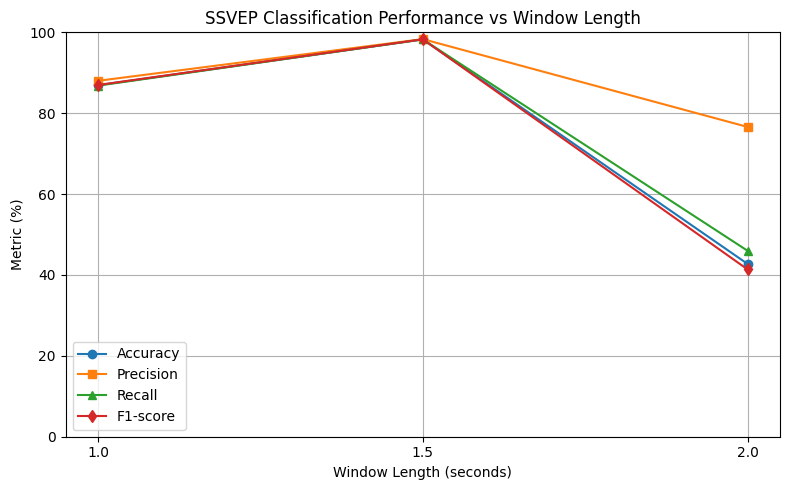

In [ ]:


import matplotlib.pyplot as plt

# Data from your runs (averaged where provided)
window_lengths = [1.0, 1.5, 2.0]  # seconds
accuracy = [86.921, 98.259, 42.742]
precision = [88.012, 98.324, 76.606]
recall = [86.826, 98.253, 45.990]
f1 = [86.982, 98.272, 41.381]

plt.figure(figsize=(8, 5))
plt.plot(window_lengths, accuracy, marker='o', label='Accuracy')
plt.plot(window_lengths, precision, marker='s', label='Precision')
plt.plot(window_lengths, recall, marker='^', label='Recall')
plt.plot(window_lengths, f1, marker='d', label='F1-score')
plt.xlabel('Window Length (seconds)')
plt.ylabel('Metric (%)')
plt.title('SSVEP Classification Performance vs Window Length')
plt.grid(True)
plt.ylim(0, 100)
plt.xticks(window_lengths, [str(w) for w in window_lengths])
plt.legend()
plt.tight_layout()
plt.savefig('/mnt/data/window_length_performance.png', dpi=200)

'/mnt/data/window_length_performance.png'
